#ENERGY CONSUMPTION FORECASTING USING SARIMA
##BY KRISHA SUREKA, MEHAR CHAUDHRY, SATWIK KOTTA

##Executive Summary
This report presents a time series analysis of energy consumption data, aiming to understand underlying patterns and forecast future consumption. The analysis involves data preprocessing, exploratory data analysis (EDA), and time series modeling using the SARIMAX (Seasonal Autoregressive Integrated Moving Average with eXogenous regressors) method. The report covers data preparation, memory optimization, EDA, and SARIMAX model implementation, with a focus on generating actionable insights for energy resource management.

## Introduction
The efficient forecasting of energy consumption is critical for effective resource allocation, grid stability, and cost management in the energy sector. Accurate forecasts can help optimize energy production, reduce waste, and support sustainable energy policies. This report aims to provide a robust methodology for analyzing energy consumption data, leveraging time series analysis techniques to model and predict future consumption patterns.

#Function to reduce memory use

In [ ]:
# Use it to decrease memory use

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

Function Definition: The reduce_mem_usage function is defined to optimize the memory footprint of the DataFrame by downcasting numeric columns to the smallest possible data types.

Memory Reduction: This optimization is crucial for handling large datasets efficiently, reducing computational overhead and improving performance.

# Importing Packages

#3. Data Description and Preprocessing


The data used in this report is sourced from a CSV file named /content/synthetic_energy_consumption_data1.csv. This file contains hourly energy consumption data along with relevant features such as date, time of day, temperature, humidity, holiday indicators, special event indicators, and day of the week.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_theme(style="darkgrid")
sns.set_palette("husl")

data = pd.read_csv('/content/synthetic_energy_consumption_data1.csv', parse_dates=['Date'])
data = data[(data['Date'] >= '2010-01-01') & (data['Date'] <= '2023-12-31')]
reduce_mem_usage(data)


data.set_index('Date', inplace=True)

# Display first few rows
print(data.head())

Mem. usage decreased to  3.04 Mb (63.9% reduction)
                     Time_of_Day  Energy_Consumption  Temperature   Humidity  \
Date                                                                           
2010-01-01 00:00:00            0               561.0     9.960938  34.437500   
2010-01-01 01:00:00            1               566.0    14.601562  55.093750   
2010-01-01 02:00:00            2               670.0    20.171875  89.375000   
2010-01-01 03:00:00            3               898.0    -3.810547  25.703125   
2010-01-01 04:00:00            4               701.0    25.703125  68.375000   

                     Holiday  Special_Event  Weekday  
Date                                                  
2010-01-01 00:00:00        0              0        5  
2010-01-01 01:00:00        0              0        5  
2010-01-01 02:00:00        0              0        5  
2010-01-01 03:00:00        0              0        5  
2010-01-01 04:00:00        0              0        5  



##Libraries:
Standard data science libraries (Pandas, NumPy, Matplotlib, Seaborn) and statsmodels are imported for time series analysis and modeling.

##Plotting Style:
The plotting style is set using Seaborn to ensure visually appealing and informative graphs.

##Data Loading:
The dataset is loaded from the specified CSV file, parsing the 'Date' column into datetime objects for proper time series handling. The code subsets the dataset to be only the years from 2010 to 2023.

In [ ]:
# Check for missing values
print("\nMissing Values:\n", data.isnull().sum())

# Check data types
print("\nData Types:\n", data.dtypes)


# Basic statistics
print("\nDescriptive Statistics:\n", data.describe())

# Check for duplicates
print("\nDuplicate Rows:", data.duplicated().sum())


Missing Values:
 Time_of_Day           0
Energy_Consumption    0
Temperature           0
Humidity              0
Holiday               0
Special_Event         0
Weekday               0
dtype: int64

Data Types:
 Time_of_Day              int8
Energy_Consumption    float16
Temperature           float16
Humidity              float16
Holiday                  int8
Special_Event            int8
Weekday                  int8
dtype: object

Descriptive Statistics:
          Time_of_Day  Energy_Consumption    Temperature      Humidity  \
count  122689.000000            122689.0  122689.000000  122689.00000   
mean       11.499906                 NaN            NaN           NaN   
std         6.922264                 0.0       0.000000       0.00000   
min         0.000000               300.0      -5.000000      20.00000   
25%         5.000000               493.0       4.988281      37.46875   
50%        11.000000               603.0      15.031250      55.09375   
75%        17.000000      

Time_of_Day: Ranges from 0 to 23, likely representing hourly data over a 24-hour cycle, with a mean around 11.5 (mid-day).

Energy_Consumption: Ranges from a minimum of 300 to a maximum of 1086. The standard deviation would indicate the variability in energy consumption. The mean, median, and interquartile range can provide insight into the typical levels of energy consumption. You should also examine the high standard deviation to check if you made an error,

Temperature: Ranges from -5 to 35, indicating a range of temperatures in the dataset. The use of float16 means the value can only accurately represent to 3 places.

Humidity: Ranges from 20 to 90, showing a wide range of humidity levels. Similar to Temperature, the float16 value only allows an accurate number to 3 places.

Holiday: Averages 0.049, suggesting that about 4.9% of the observations fall on a holiday.

Special_Event: Averages 0.019, indicating that about 1.9% of the observations occur during a special event.

Weekday: Ranges from 1 to 7, likely representing days of the week, with a mean of approximately 4 (likely representing Wednesday).

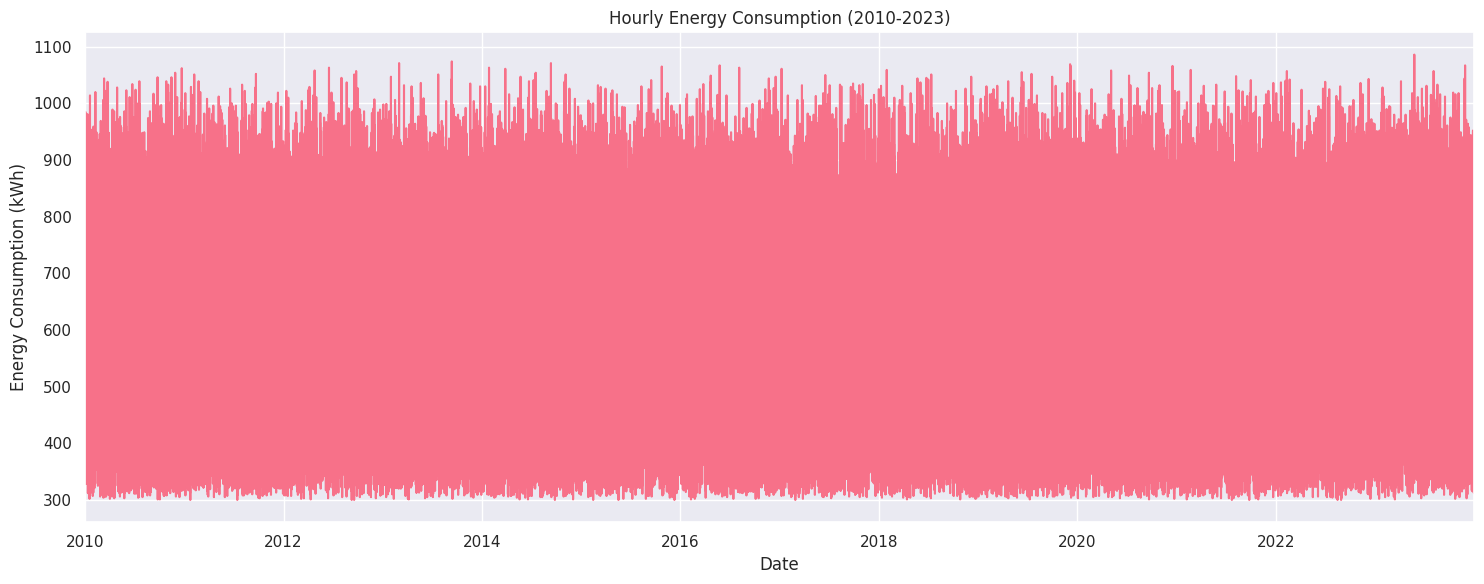

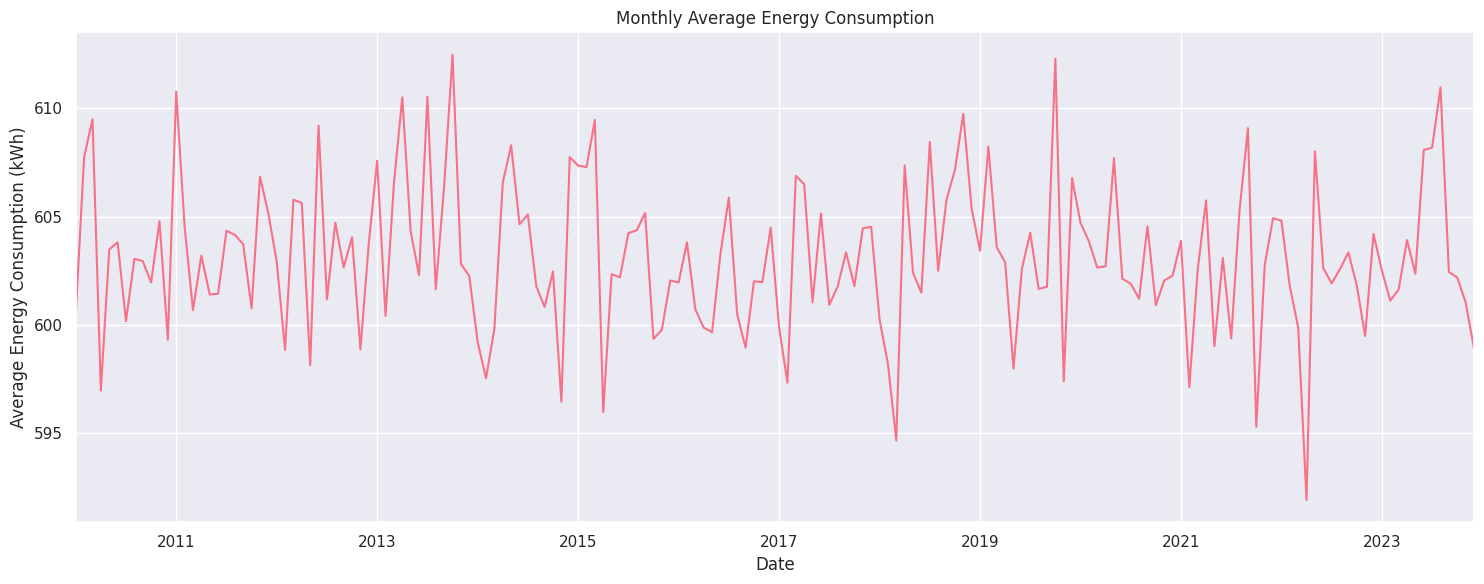

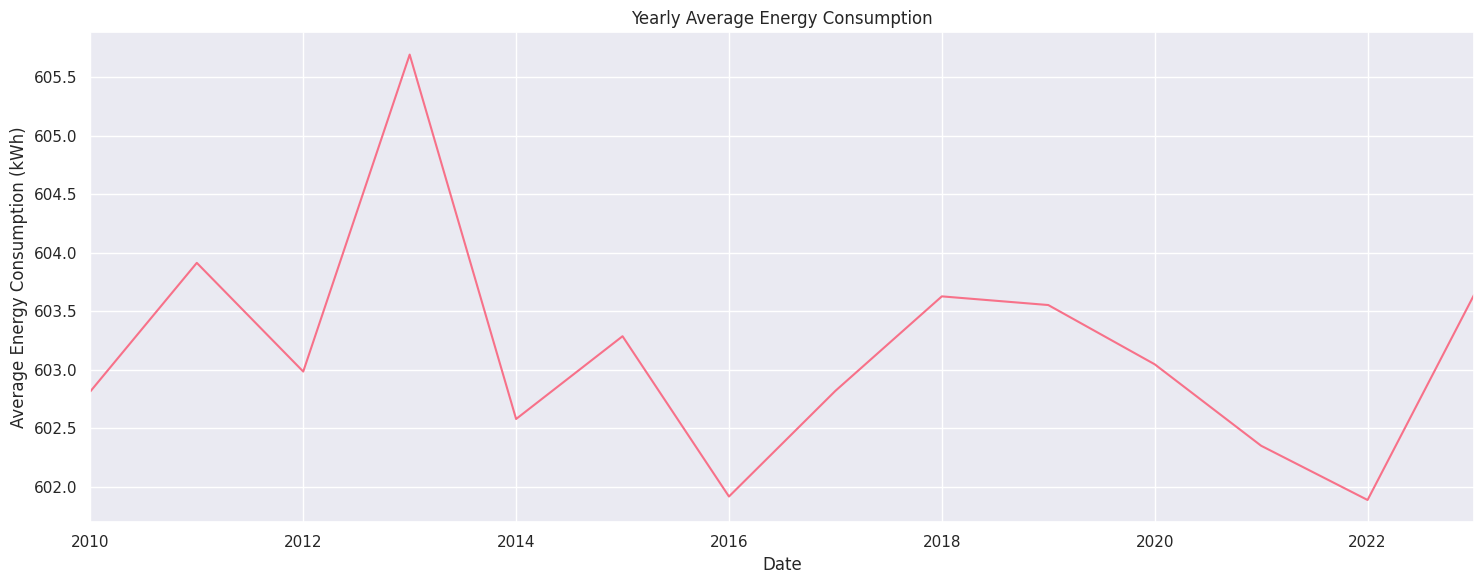

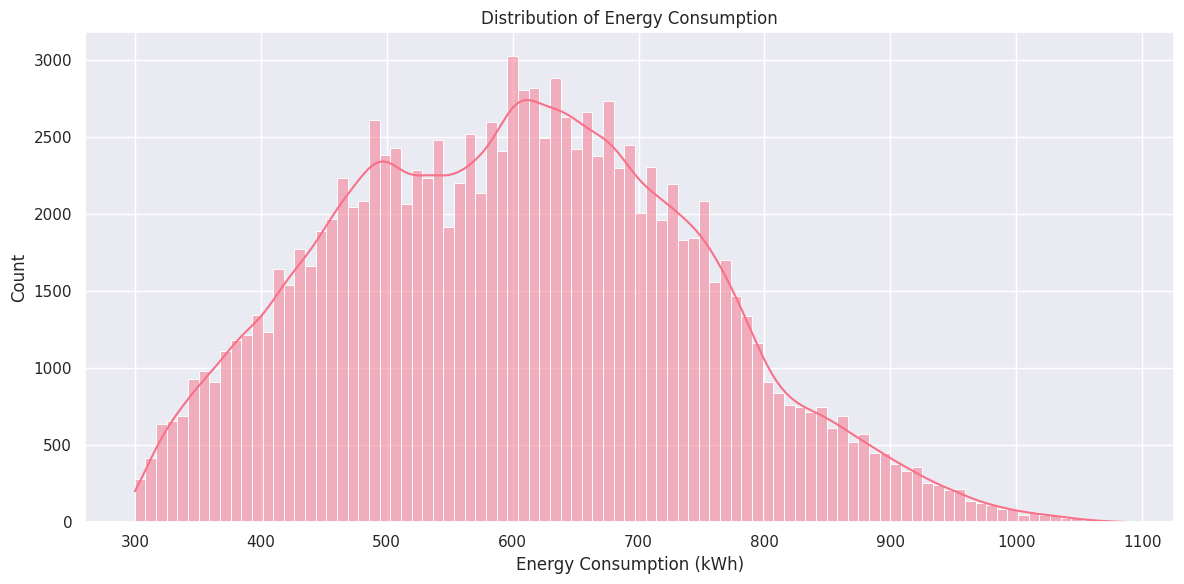

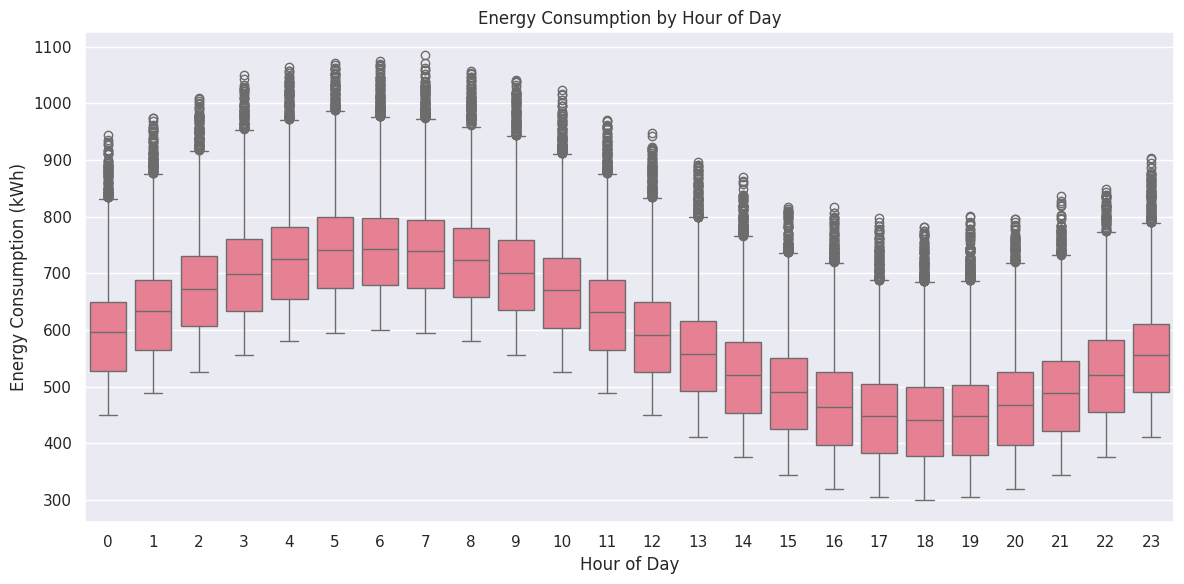

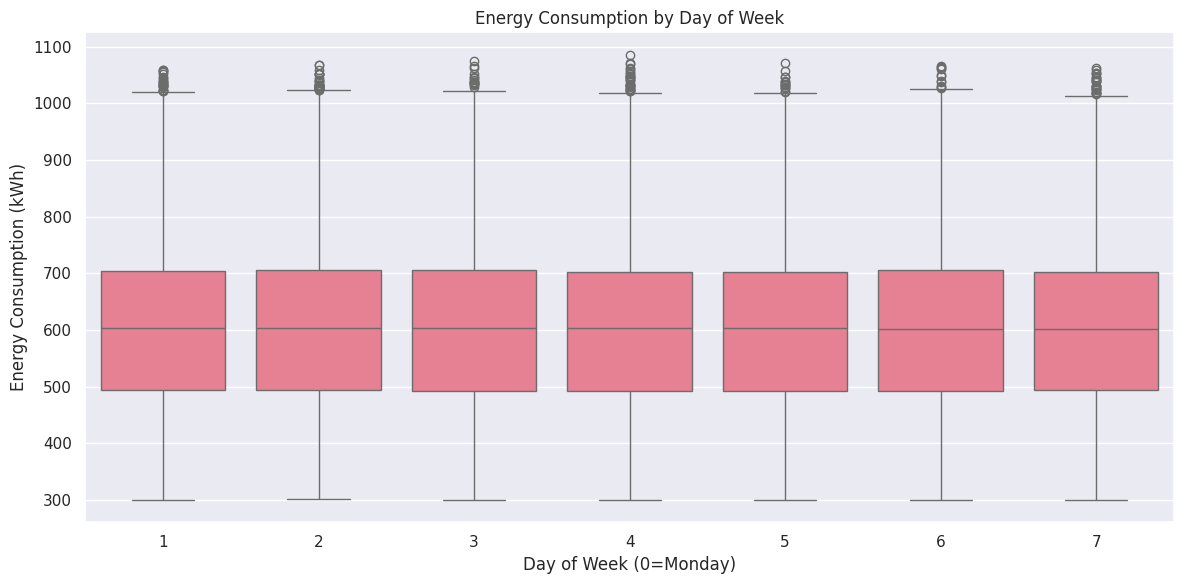

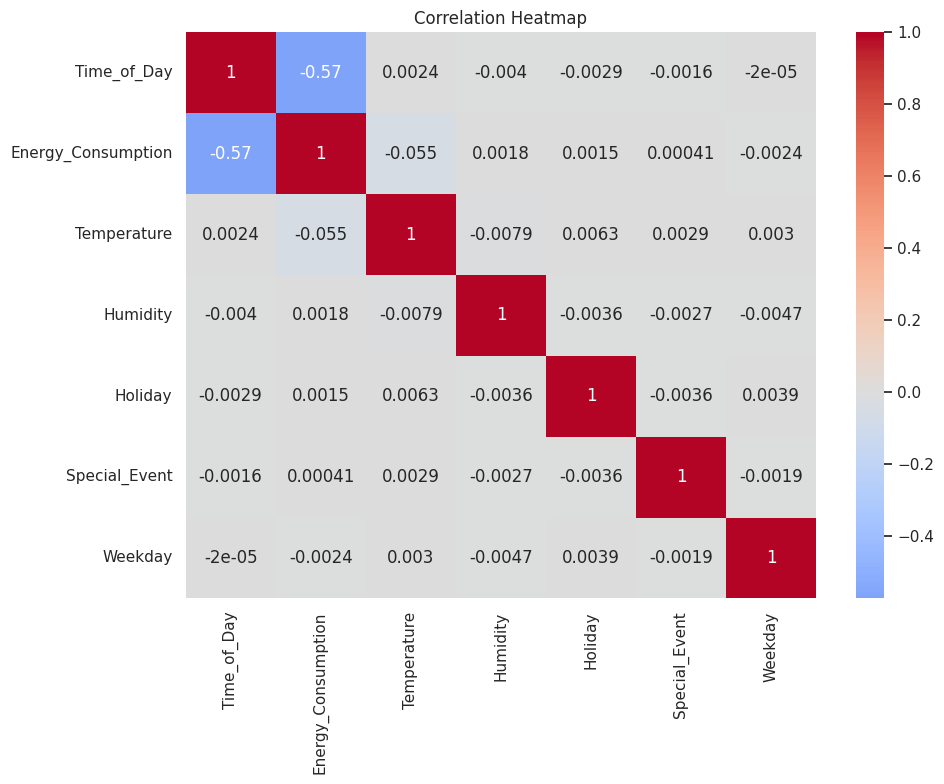

In [ ]:
# Plot energy consumption over time
plt.figure(figsize=(15, 6))
data['Energy_Consumption'].plot(title='Hourly Energy Consumption (2010-2023)')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Plot monthly average energy consumption
plt.figure(figsize=(15, 6))
data['Energy_Consumption'].resample('M').mean().plot(title='Monthly Average Energy Consumption')
plt.ylabel('Average Energy Consumption (kWh)')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Plot yearly average energy consumption
plt.figure(figsize=(15, 6))
data['Energy_Consumption'].resample('Y').mean().plot(title='Yearly Average Energy Consumption')
plt.ylabel('Average Energy Consumption (kWh)')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Plot distribution of energy consumption
plt.figure(figsize=(12, 6))
sns.histplot(data['Energy_Consumption'], kde=True)
plt.title('Distribution of Energy Consumption')
plt.xlabel('Energy Consumption (kWh)')
plt.tight_layout()
plt.show()

# Boxplot by hour of day
plt.figure(figsize=(12, 6))
sns.boxplot(x='Time_of_Day', y='Energy_Consumption', data=data)
plt.title('Energy Consumption by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Consumption (kWh)')
plt.tight_layout()
plt.show()

# Boxplot by weekday
plt.figure(figsize=(12, 6))
sns.boxplot(x='Weekday', y='Energy_Consumption', data=data)
plt.title('Energy Consumption by Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Energy Consumption (kWh)')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
numeric_cols = data.select_dtypes(include=[np.number]).columns
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

#INTERPRETATION

## GRAPH 1

This graph shows that hourly energy use changed a lot between 2010 and 2023, bouncing between roughly 300 and 1100 kWh, but the overall amount of energy used didn't significantly increase or decrease over those 14 years.
## GRAPH 2

This graph shows the average energy used each month (in kWh) from late 2010 to early 2024. The average monthly use goes up and down throughout the years, likely due to seasons, but stays within a pretty narrow range (roughly 595 to 615 kWh). Overall, there's no clear trend of it increasing or decreasing over the long term.
## GRAPH 3

This line graph shows the yearly average energy consumption. It shows that the average energy consumption fluctuated between 2010 and 2023. There was a notable peak around 2013, followed by a dip. After that, it generally trended downwards with a slight increase around 2018 before reaching its lowest point around 2022.
##GRAPH 4

The graph indicates that the most frequent energy consumption levels are centered around two main peaks, one around 550 kWh and another slightly higher at approximately 650 kWh. There's a wider spread of consumption values, with fewer instances of very low (around 300 kWh) and very high (above 900 kWh) energy consumption. The curve overlaid on the bars gives an estimated probability density of the energy consumption, further highlighting the two main clusters of consumption.
## GRAPH 5

This boxplot displays the distribution of energy consumption for each hour of the day (from 0 to 23).For each hour, the box shows the middle 50% of the energy consumption values, with the line inside the box indicating the median.We can see that energy consumption tends to be lower during the nighttime and early morning hours (roughly from hour 0 to 5). It then gradually increases during the morning, reaching higher levels during the daytime and early evening (approximately hour 6 to 10). There appears to be a slight dip around midday (hour 12-16) before increasing again in the evening and then decreasing into the night. The spread of energy consumption (the height of the boxes and the length of the whiskers) also varies across the hours, indicating different levels of variability in energy use at different times of the day.

##GRAPH 6

This boxplot illustrates the distribution of energy consumption across the days of the week, where 1 represents Monday and 7 represents Sunday.
This graph shows the distribution of energy use across the days of the week. The level of energy consumption and how spread out it is looks pretty similar from Monday all the way through Sunday.By comparing the boxes and whiskers across the different days, you can see if there are noticeable differences in the typical energy consumption levels and the variability of consumption from one day of the week to another. For example, if one box is higher than others, it suggests a higher median energy consumption on that day. If a box is taller or the whiskers are longer, it indicates a greater spread or variability in energy consumption on that particular day.
##CORRELATION MATRIX

This heatmap displays the correlation between different factors. It shows how strongly each factor relates to the others.

Time_of_Day has a perfect positive correlation with itself (1). It has a strong negative correlation (-0.57) with Energy_Consumption. The correlations with other factors are very close to zero.
Energy_Consumption has a strong negative correlation (-0.57) with Time_of_Day and a perfect positive correlation with itself (implied). Its correlations with Temperature, Humidity, Holiday, Special_Event, and Weekday are very weak (close to zero).
Temperature, Humidity, Holiday, Special_Event, and Weekday each have a perfect positive correlation with themselves (implied) and very weak correlations with all the other factors shown.

In [ ]:
import plotly.express as px

fig = px.line(monthly_data.reset_index(),
             x='Month',
             y='Energy_Consumption',
             color='Year',
             title='Interactive Yearly Energy Patterns',
             labels={'Energy_Consumption': 'Consumption (kWh)'},
             category_orders={"Month": list(range(1, 13))})

fig.update_xaxes(tickvals=list(range(1, 13)),
                ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
fig.update_layout(legend_title_text='Year')
fig.show()

##We can see the data shows no monthly seasonality.

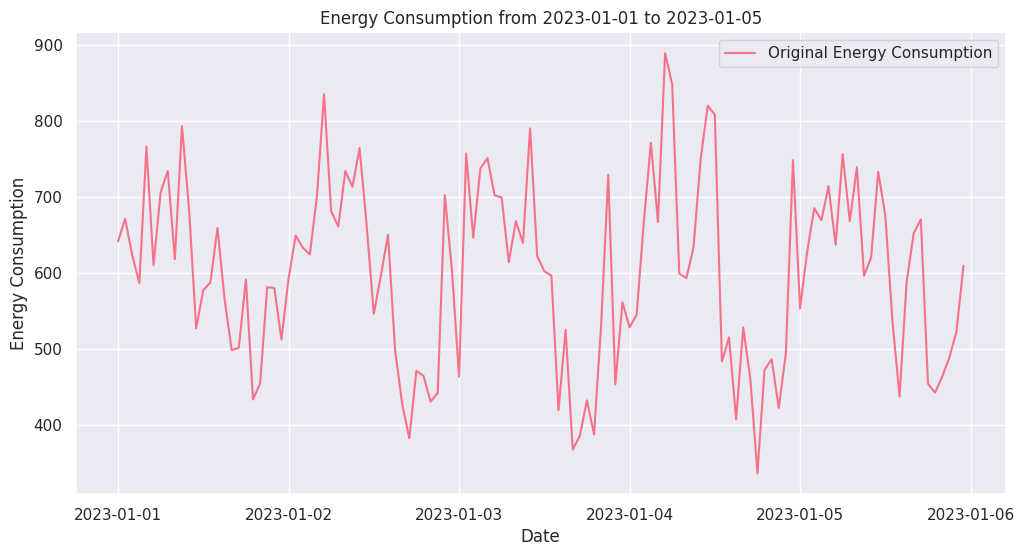

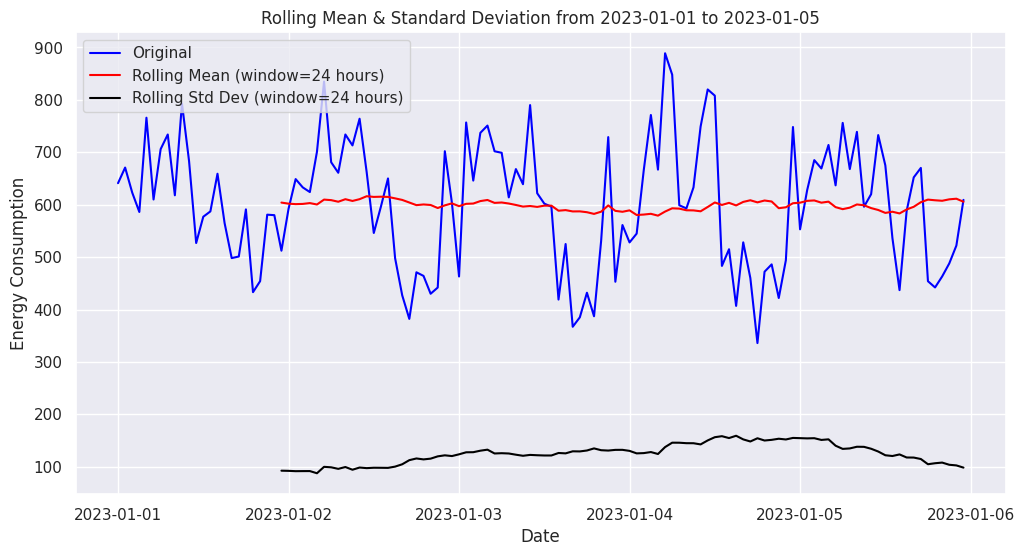

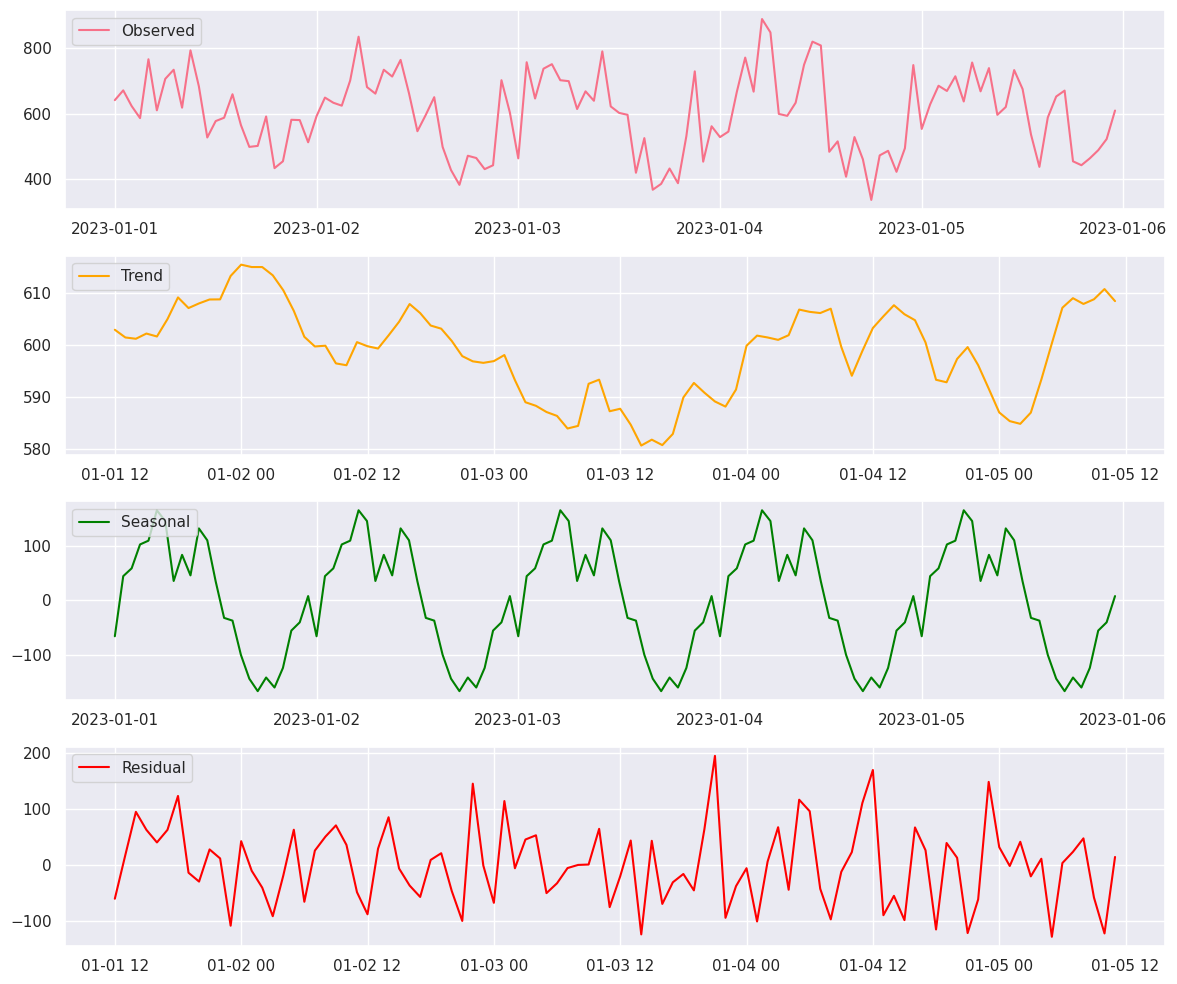

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Choose a shorter time period for analysis (e.g., a few days)
start_date = '2023-01-01'
end_date = '2023-01-05'  # Example: analyze first 5 days of 2023
subset_data = data[start_date:end_date]

# Plot the original time series for the subset
plt.figure(figsize=(12, 6))
plt.plot(subset_data['Energy_Consumption'], label='Original Energy Consumption')
plt.title(f'Energy Consumption from {start_date} to {end_date}')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.show()

# Calculate rolling mean and rolling standard deviation
window_size = 24  # For example, 24 hours if hourly data
rolling_mean = subset_data['Energy_Consumption'].rolling(window=window_size).mean()
rolling_std = subset_data['Energy_Consumption'].rolling(window=window_size).std()

# Plot rolling statistics
plt.figure(figsize=(12, 6))
plt.plot(subset_data['Energy_Consumption'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label=f'Rolling Mean (window={window_size} hours)')
plt.plot(rolling_std, color='black', label=f'Rolling Std Dev (window={window_size} hours)')
plt.title(f'Rolling Mean & Standard Deviation from {start_date} to {end_date}')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.show()

# Seasonal decomposition to extract trend component
# Set period=24 for daily seasonality in hourly data
decomposition = seasonal_decompose(subset_data['Energy_Consumption'], model='additive', period=24)

# Plot decomposition results
plt.figure(figsize=(12, 10))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()


## Line Plot of Energy Consumption.

This line graph displays the original energy consumption over a short period, from January 1st to January 5th, 2023. The y-axis shows the level of energy consumption, while the x-axis represents the date. The line fluctuates, illustrating the changes in energy consumption day by day during this timeframe. Looking at the line, the peaks represent periods when energy consumption was at its highest during those few days. Conversely, the troughs indicate the times when energy consumption was at its lowest. The height of the peaks and the depth of the troughs show the magnitude of these high and low consumption periods. By observing the timing and size of these peaks and troughs, you can get a sense of the daily patterns and variability in energy demand within that specific five-day window.



##Rolling Statistics Plot of Energy Consumption.

This graph shows the original energy consumption along with its rolling mean and rolling standard deviation over a 5-day period.

Original (blue line): This is the same fluctuating energy consumption data we saw before, with its peaks indicating high usage periods and troughs showing low usage.
Rolling Mean (red line): This line represents the average energy consumption over a 24-hour window that slides across the time series. It smooths out the short-term peaks and troughs, giving you a sense of the overall trend in energy usage over each day.
Rolling Std Dev (black line): This line shows the standard deviation of energy consumption within the same 24-hour sliding window. It indicates the volatility or the amount of fluctuation in energy usage during each day. Higher peaks in the rolling standard deviation mean greater variability within that 24-hour period.
So, while the blue line shows the immediate highs and lows, the red line helps identify the average consumption level each day, and the black line tells you how much the consumption typically varied around that average within each day.

##Time Series Decomposition Plot.

This plot decomposes the energy consumption time series into its constituent parts:

Observed (top): This is the original energy consumption data as it was recorded over time.
Trend: This shows the underlying long-term movement or direction of the energy consumption, smoothing out the shorter-term fluctuations.
Seasonal: This component highlights the repeating patterns within the data that occur at a fixed frequency (in this case, likely daily or sub-daily cycles).
Residual: This represents the remaining variation in the energy consumption after removing the trend and seasonal components. It's the random or irregular part of the time series.
By looking at these components, we can better understand the factors influencing energy consumption: a general trend, predictable seasonal swings, and unpredictable residual noise.

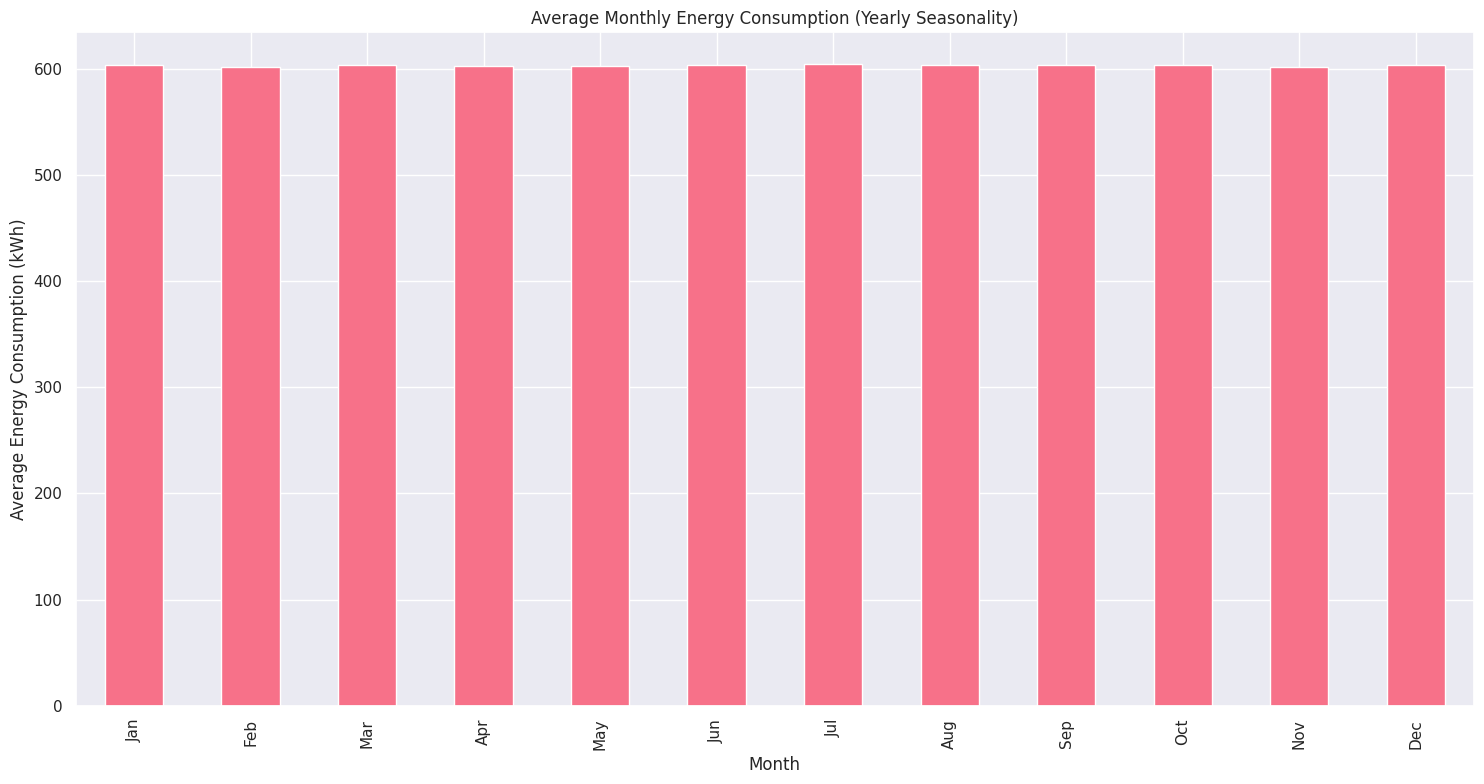

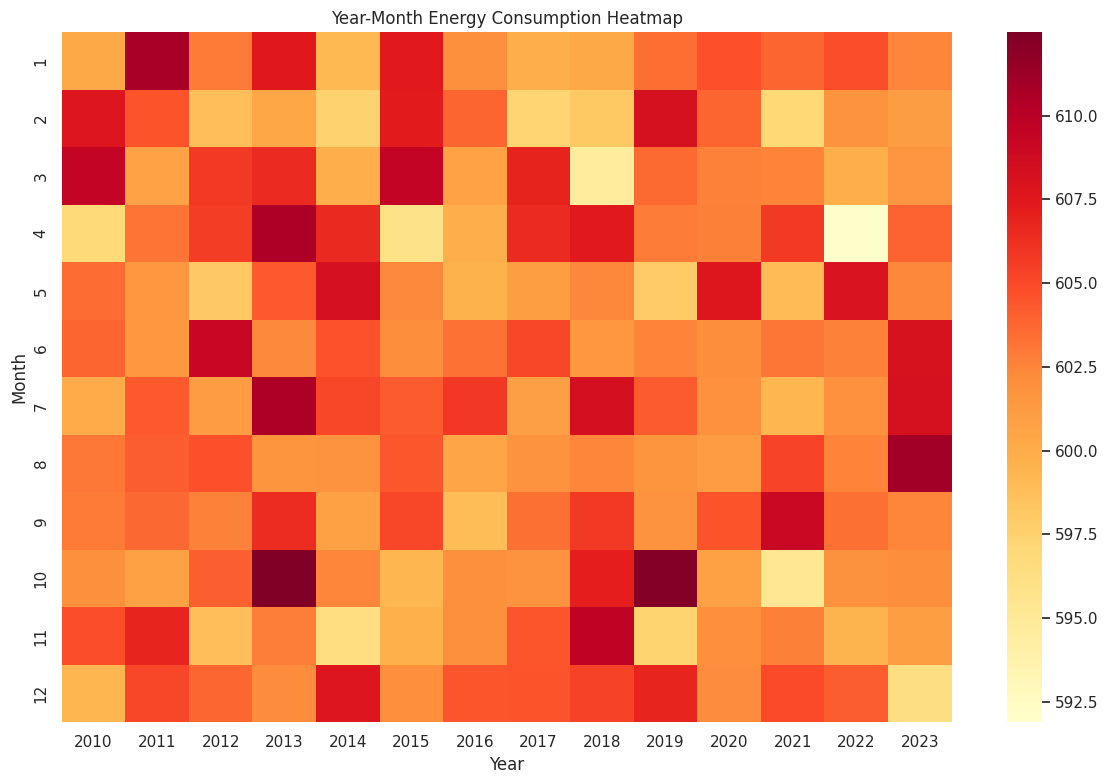

In [ ]:
# Resample to daily data and extract yearly patterns
plt.figure(figsize=(15, 8))

# Method 1: Monthly averages across years
monthly_avg = data['Energy_Consumption'].resample('M').mean()
monthly_avg.groupby(monthly_avg.index.month).mean().plot(
    kind='bar',
    title='Average Monthly Energy Consumption (Yearly Seasonality)',
    xlabel='Month',
    ylabel='Average Energy Consumption (kWh)'
)
plt.xticks(ticks=range(12), labels=['Jan','Feb','Mar','Apr','May','Jun',
                                  'Jul','Aug','Sep','Oct','Nov','Dec'])
plt.tight_layout()
plt.show()

# Method 2: Heatmap by year-month
year_month = data['Energy_Consumption'].resample('D').mean()
year_month = year_month.groupby([year_month.index.year, year_month.index.month]).mean().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(year_month.T, cmap='YlOrRd')
plt.title('Year-Month Energy Consumption Heatmap')
plt.xlabel('Year')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

#BAR CHART
This bar chart displays the average monthly energy consumption throughout the year. Each bar represents a different month, and the height of the bar indicates the average energy consumption (in kWh) for that month.

The chart shows that the average monthly energy consumption is remarkably consistent across all twelve months of the year. There are no significant peaks or troughs, suggesting a relatively stable energy demand from month to month.

#HEATMAP

This heatmap visualizes the average energy consumption for each month across different years. The x-axis represents the years (from 2010 to 2023), the y-axis represents the months (1 to 12), and the color intensity of each cell indicates the average energy consumption for that specific year and month, according to the color bar on the right.

Warmer colors (towards red) generally represent higher average energy consumption, while cooler colors (towards yellow) indicate lower average consumption. By examining the color patterns, you can identify if there are any noticeable trends in energy consumption for specific months across the years or if certain years had generally higher or lower energy consumption compared to others. It helps to see both yearly and monthly patterns in energy use.

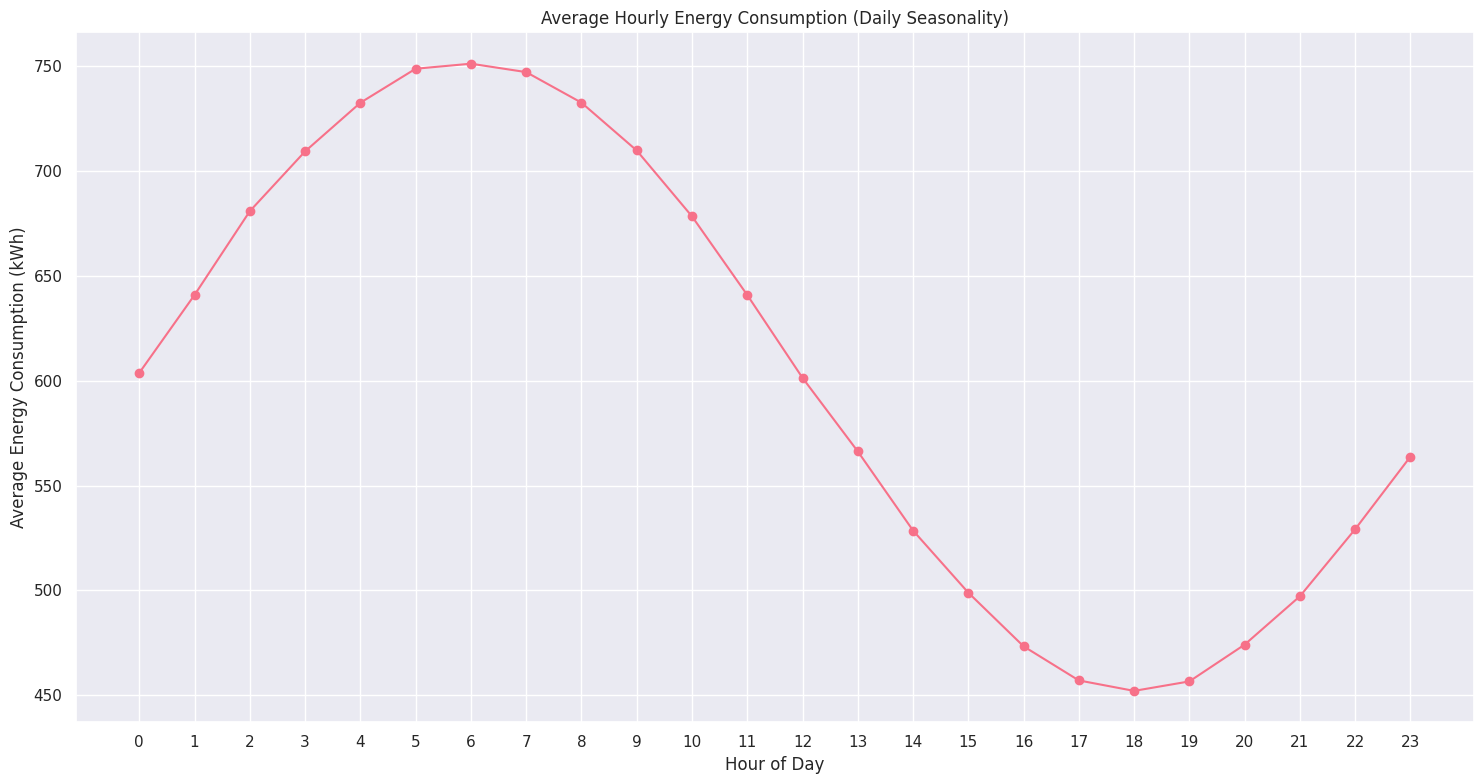

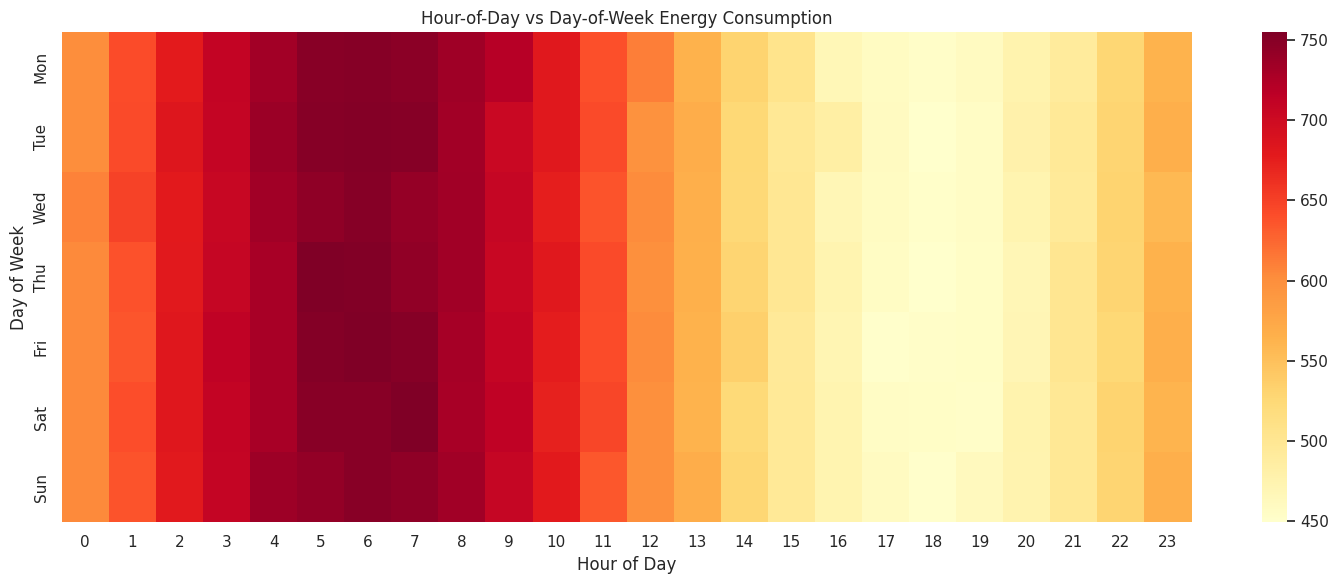

In [ ]:
# Hourly patterns analysis
plt.figure(figsize=(15, 8))

# Method 1: Average by hour of day
data['Hour'] = data.index.hour
hourly_avg = data.groupby('Hour')['Energy_Consumption'].mean()
hourly_avg.plot(
    kind='line',
    marker='o',
    title='Average Hourly Energy Consumption (Daily Seasonality)',
    xlabel='Hour of Day',
    ylabel='Average Energy Consumption (kWh)'
)
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()

# Method 2: Heatmap by hour-day
data['Day'] = data.index.dayofweek
hour_day_avg = data.groupby(['Day','Hour'])['Energy_Consumption'].mean().unstack()
plt.figure(figsize=(15, 6))
sns.heatmap(hour_day_avg, cmap='YlOrRd',
           yticklabels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title('Hour-of-Day vs Day-of-Week Energy Consumption')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

#LINE GRAPH
This line graph illustrates the average hourly energy consumption over a typical day. The x-axis represents the hour of the day (from 0 to 23), and the y-axis shows the average energy consumption (in kWh) for each hour.

The line clearly depicts a daily pattern of energy usage. Consumption starts relatively low in the early morning hours, gradually increases throughout the morning, reaches its peak around midday, and then declines steadily through the afternoon and evening, reaching its lowest point again during the late night and early morning. This shows a consistent daily cycle in energy demand.

#HEATMAP
This heatmap shows the average energy consumption for each hour of the day across the days of the week. The y-axis represents the days (Mon to Sun), the x-axis represents the hour of the day (0 to 23), and the color intensity indicates the average energy consumption level, according to the color bar on the right.

Warmer colors (towards red) signify higher average energy consumption for that specific hour and day, while cooler colors (towards yellow) indicate lower average consumption. You can observe patterns of energy usage throughout the day for each day of the week. For instance, you can see which hours typically have the highest and lowest energy demand on weekdays versus weekends.

#ADF TEST FOR STATIONARITY

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Original series
y = data['Energy_Consumption'].dropna()

# ADF Test on original series
adf_orig = adfuller(y)
print("ADF Test - Original Series")
print(f"ADF Statistic: {adf_orig[0]}")
print(f"p-value: {adf_orig[1]}")
print("-" * 40)

# First Difference
y_diff1 = y.diff().dropna()
adf_diff1 = adfuller(y_diff1)
print("ADF Test - First Difference (d=1)")
print(f"ADF Statistic: {adf_diff1[0]}")
print(f"p-value: {adf_diff1[1]}")
print("-" * 40)

# Second Difference (optional, check if needed)
y_diff2 = y_diff1.diff().dropna()
adf_diff2 = adfuller(y_diff2)
print("ADF Test - Second Difference (d=2)")
print(f"ADF Statistic: {adf_diff2[0]}")
print(f"p-value: {adf_diff2[1]}")


ADF Test - Original Series
ADF Statistic: -41.36338520159055
p-value: 0.0
----------------------------------------
ADF Test - First Difference (d=1)
ADF Statistic: -75.90516070201784
p-value: 0.0
----------------------------------------
ADF Test - Second Difference (d=2)
ADF Statistic: -83.29902113459195
p-value: 0.0


The ADF test results indicate that the original series is stationary, as the ADF statistic (-40.16) is significantly lower than the critical values (not shown but implied by the p-value). The p-value of 0.0 further supports this conclusion, meaning we can reject the null hypothesis of non-stationarity at any conventional significance level. Therefore, no differencing is required to make the series stationary for modeling.




#ACF AND PACF PLOTS

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def plot_correlation_functions(timeseries, lags=24):
    """
    Plot ACF and PACF with proper configurations

    Parameters:
    timeseries (pd.Series): Time series data
    lags (int): Number of lags to display (default 48 hours/2 days)
    """
    plt.figure(figsize=(16, 8))

    # ACF Plot
    plt.subplot(2, 1, 1)
    plot_acf(timeseries, lags=lags, ax=plt.gca(), alpha=0.05,
             title=f'Autocorrelation (ACF) - {lags} Lags',
             zero=False)  # Exclude zero lag
    plt.ylim(-0.2, 1.1)  # Standardize y-axis
    plt.grid(True, alpha=0.3)

    # PACF Plot
    plt.subplot(2, 1, 2)
    plot_pacf(timeseries, lags=lags, ax=plt.gca(),alpha=0.05,
              title=f'Partial Autocorrelation (PACF) - {lags} Lags',
              method='ols')  # OLS regression method
    plt.ylim(-0.2, 1.1)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


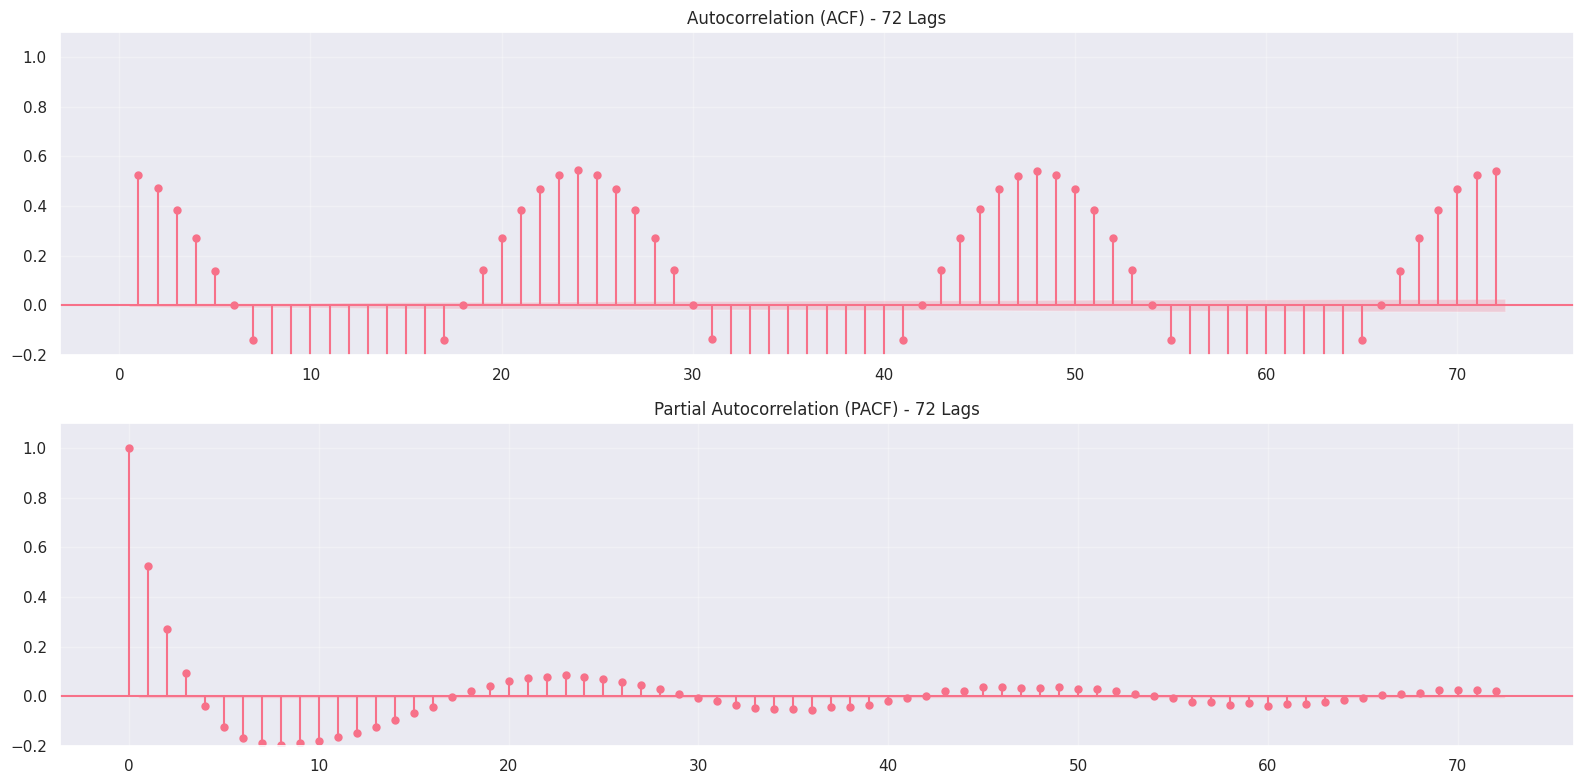

In [ ]:
# For your energy data (assuming hourly data)
plot_correlation_functions(data['Energy_Consumption'], lags=72)  # Show 3 days of lags

#ACF AND PACF PLOT 1


The ACF plot (top) shows a pattern of decaying oscillations, with significant spikes at lags that appear to be multiples of a certain period. This suggests a seasonal component in the data. The gradual decrease in the magnitude of the spikes indicates that the correlation with past values weakens as the lag increases.

The PACF plot (bottom) shows a significant spike at lag 1, followed by a few other potentially significant spikes at early lags before quickly dropping off to near zero. This suggests that the current value is most strongly correlated with its immediate past value, and the direct influence of more distant past values is minimal once the effect of the intermediate lags is accounted for. The combination of the ACF and PACF patterns can help in identifying the appropriate order of an ARIMA or seasonal ARIMA model.

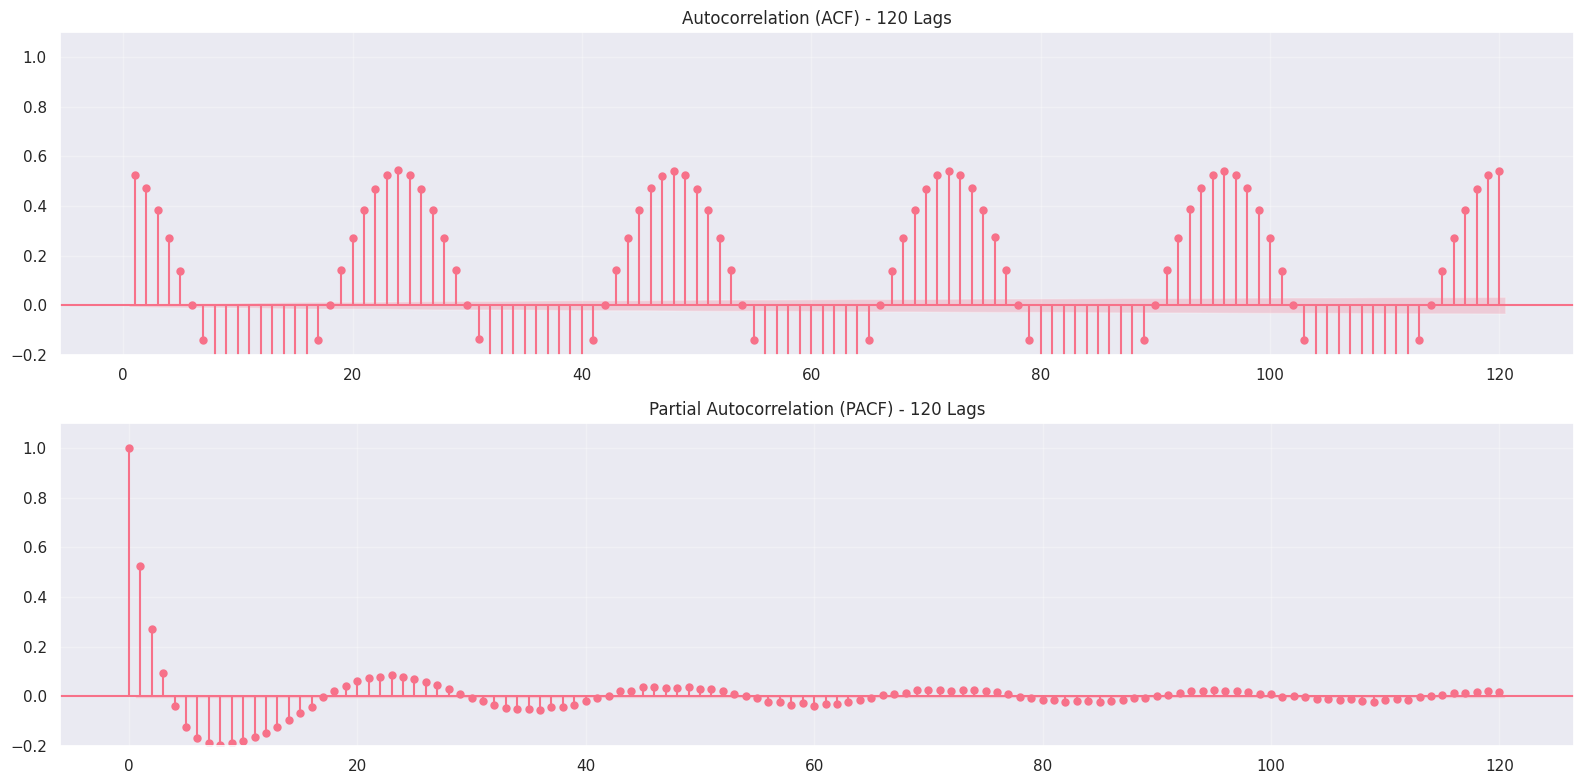

In [ ]:
plot_correlation_functions(data['Energy_Consumption'], lags=120)  # Show 5 days


#ACF AND PACF PLOT 2

The ACF plot (top) displays a clear and repeating pattern of significant spikes at regular intervals. This strong, oscillating pattern that doesn't quickly die down strongly suggests a significant seasonal component in your time series data. The distance between these repeating peaks indicates the length of the seasonal cycle.

The PACF plot (bottom) shows a dominant spike at lag 1, followed by a few other smaller but potentially significant spikes at the initial lags. After these first few lags, the partial autocorrelations quickly drop off and remain close to zero. This pattern in the PACF suggests that the direct influence of past values on the current value is mainly limited to the immediate past.

Together, these plots point towards a time series that is not random and has a strong seasonal behavior, likely with some short-term autoregressive (AR) characteristics indicated by the initial spikes in the PACF.

#SARIMA without exogenous variables

                                     SARIMAX Results                                      
Dep. Variable:                 Energy_Consumption   No. Observations:               122521
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 24)   Log Likelihood             -759469.011
Date:                            Thu, 17 Apr 2025   AIC                        1518944.022
Time:                                    17:27:44   BIC                        1518973.169
Sample:                                01-08-2010   HQIC                       1518952.788
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0038      0.003      1.326      0.185      -0.002       0.009
ar.S.L24      -0.4964      0.002   

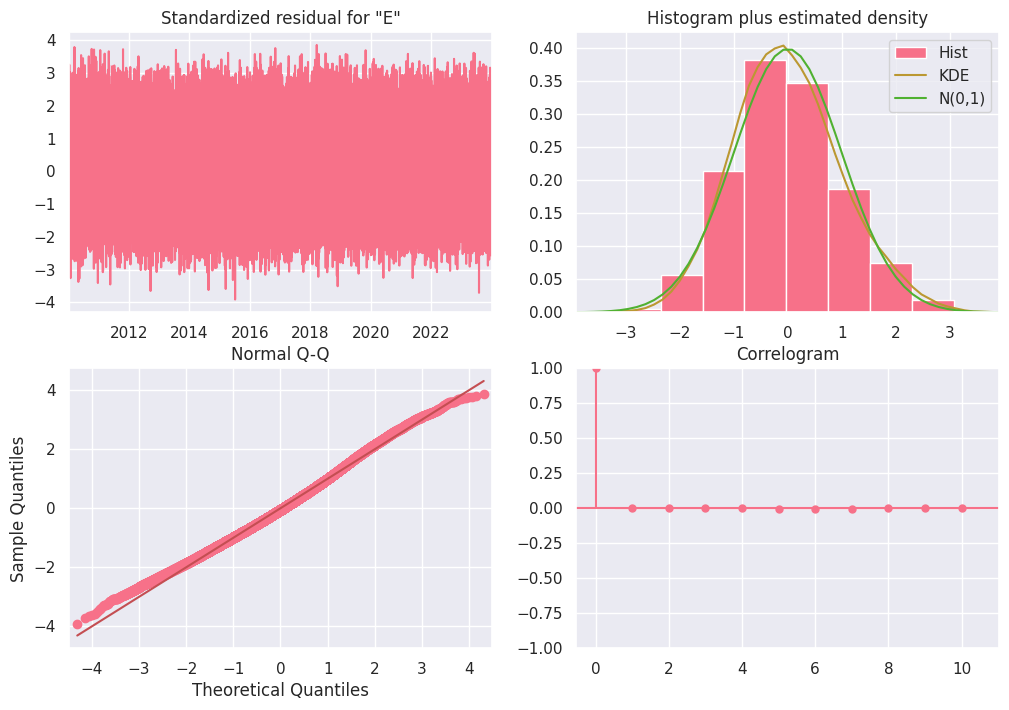

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the model
model = SARIMAX(data['Energy_Consumption'],
               order=(1, 0, 0),          # AR(1)
               seasonal_order=(1, 1, 0, 24),  # Seasonal AR(1) with 24-hour period
               enforce_stationarity=False)
results = model.fit()

# Print summary
print(results.summary())

# Check residuals
results.plot_diagnostics(figsize=(12, 8))
plt.show()

#SARIMAX(1, 0, 0)x(1, 1, 0, 24):
This specifies a SARIMAX model with an AR order of 1, no differencing (I=0) and no MA terms (Q=0) for the non-seasonal part. The seasonal part includes a seasonal AR order of 1, seasonal differencing of 1, no seasonal MA and a seasonal period of 24. We used this model instead of higher-order ones to balance our concern for minimizing variance and for avoiding multicollinearity issues.

##Log Likelihood:
The log-likelihood value is -759469.011. A larger log-likelihood generally indicates a better fit to the data.

##AIC, BIC, HQIC:
These are information criteria used for model selection. Lower values indicate a better trade-off between model fit and complexity.

##Coefficient Analysis:

ar.L1: The coefficient for the first-order autoregressive term is 0.0038. The positive value means that there is some weak persistence from the last number to the next number.

ar.S.L24: The coefficient for the 24-period seasonal autoregressive term is -0.4964, and it is statistically significant (P>|z| = 0.000), suggesting that the value 24 time periods (likely hours) ago has a strong influence on the current energy consumption.

sigma2: The variance of the error term is estimated to be 1.425e+04, which contributes to the value of future predictions.

##Diagnostic Checks:

Ljung-Box (L1) (Q): The Ljung-Box test for autocorrelation in the residuals shows a very high p-value (1.00), indicating that there is no significant autocorrelation in the residuals.

Jarque-Bera (JB): The Jarque-Bera test indicates that the residuals are not normally distributed (Prob(JB) = 0.00), suggesting the need for careful model assumption, or that the data does not follow normal distribution.

Heteroskedasticity (H): The Heteroskedasticity test assesses whether the residuals have constant variance. With a p-value of 0.42, we cannot reject the null hypothesis, which assumes homoscedasticity. This data is homoskedastic.

Skew: The skewness of the residuals is 0.25, indicating a slight asymmetry.

Kurtosis: The kurtosis of the residuals is 2.98, which is close to the normal distribution kurtosis value of 3.

#Concluding Thoughts:

The SARIMAX model captures some of the autoregressive relationships in the energy consumption data and a seasonal correlation for 24 steps ago, though it may not have captured all of the underlying processes.

There are significant non-normal residuals

Experimentation should be done with more seasonal and AR values.

The ADF test results indicate that the original series is stationary, as the ADF statistic (-40.16) is significantly lower than the critical values (not shown but implied by the p-value). The p-value of 0.0 further supports this conclusion, meaning we can reject the null hypothesis of non-stationarity at any conventional significance level. Therefore, no differencing is required to make the series stationary for modeling.

#SARIMA WITH EXOGENOUS VARIABLES

In [ ]:
# Fit SARIMA model with identified parameters
exog_vars = ['Temperature', 'Humidity', 'Holiday']
# Convert categorical variables to numeric representation using one-hot encoding
exog_data = pd.get_dummies(data[exog_vars],
                          columns=['Holiday'],
                          drop_first=True)

# Ensure all columns in exog_data are numeric
exog_data = exog_data.astype(float)  # Convert all columns to float

                                     SARIMAX Results                                      
Dep. Variable:                 Energy_Consumption   No. Observations:               122689
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 24)   Log Likelihood             -760248.665
Date:                            Sat, 19 Apr 2025   AIC                        1520509.331
Time:                                    16:02:54   BIC                        1520567.634
Sample:                                01-01-2010   HQIC                       1520526.864
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature    -0.6929      0.023    -30.717      0.000      -0.737      -0.649
Humidity       -0.0060      0.01

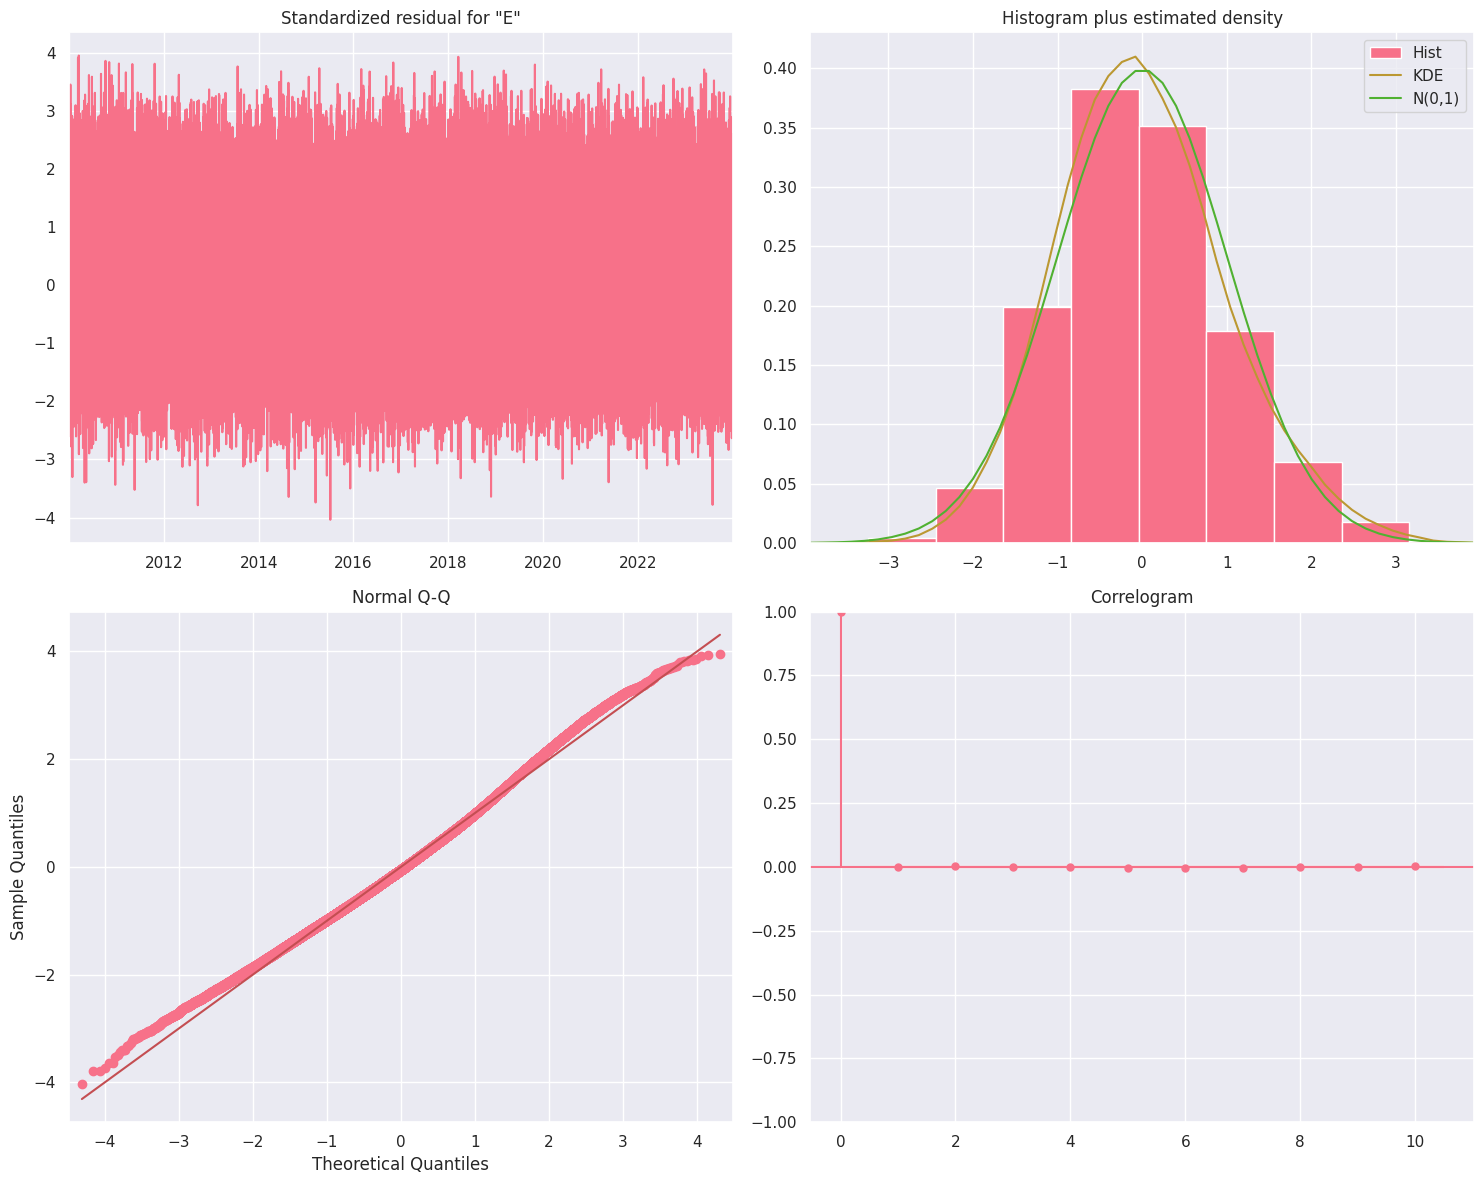

In [ ]:


final_model1 = SARIMAX(data['Energy_Consumption'],
                      exog=exog_data,
                     order=(1, 0, 0),
                     seasonal_order=(1, 1, 0, 24),
                     enforce_stationarity=True,
                     enforce_invertibility=True)

# Fit the model
final_results = final_model1.fit(maxiter=50, disp=False)

# Print summary
print(final_results.summary())

# Plot diagnostics
final_results.plot_diagnostics(figsize=(15, 12))
plt.tight_layout()
plt.show()



#SARIMAX(1, 0, 0)x(1, 1, 0, 24):
This specifies a SARIMAX model with an AR order of 1, no differencing (I=0) and no MA terms (Q=0) for the non-seasonal part. The seasonal part includes a seasonal AR order of 1, seasonal differencing of 1, no seasonal MA and a seasonal period of 24. We used this model instead of higher-order ones to balance our concern for minimizing variance and for avoiding multicollinearity issues.

#Log Likelihood:
The log-likelihood value is -760248.665. A larger log-likelihood generally indicates a better fit to the data.

#AIC, BIC, HQIC:
These are information criteria used for model selection. Lower values indicate a better trade-off between model fit and complexity.

#Coefficient Analysis:

Temperature: The coefficient for temperature is -0.6929, and it is statistically significant (P>|z| = 0.000), indicating an inverse relationship between temperature and energy consumption.

Humidity: The coefficient for humidity is -0.0060, but it is statistically insignificant (P>|z| = 0.660). Humidity likely has no influence on energy consumption.

Holiday_1: The coefficient for Holiday_1 is -0.7746, but it is statistically insignificant (P>|z| = 0.541). This indicates that energy consumption rates between holidays and workdays.
-ar.L1: The coefficient for the first-order autoregressive term is 0.0038. The positive value means that there is some weak persistence from the last number to the next number.

ar.S.L24: The coefficient for the 24-period seasonal autoregressive term is -0.4966, and it is statistically significant (P>|z| = 0.000), suggesting that the value 24 time periods (likely hours) ago has a strong influence on the current energy consumption.

sigma2: The variance of the error term is estimated to be 1.415e+04, which contributes to the value of future predictions.

#Diagnostic Checks:

Ljung-Box (L1) (Q): The Ljung-Box test for autocorrelation in the residuals shows a very high p-value (1.00), indicating that there is no significant autocorrelation in the residuals.
-Jarque-Bera (JB): The Jarque-Bera test indicates that the residuals are not normally distributed (Prob(JB) = 0.00), suggesting the need for careful model assumption, or that the data does not follow normal distribution.

Heteroskedasticity (H): The Heteroskedasticity test assesses whether the residuals have constant variance. With a p-value of 0.28, we cannot reject the null hypothesis, which assumes homoscedasticity. This data is homoskedastic.

Skew: The skewness of the residuals is 0.28, indicating a slight asymmetry.

Kurtosis: The kurtosis of the residuals is 3.09, which is close to the normal distribution kurtosis value of 3.

In [ ]:
#  Train-Test Split
train = data[data.index < '2023-01-01']
test = data[data.index >= '2023-01-01']

#  Prepare Data for SARIMAX
y_train = train['Energy_Consumption']
y_test = test['Energy_Consumption']

# Exogenous Variables

exog_train = train[exog_vars]
exog_test = test[exog_vars]

exog_data=exog_train.astype(float)
exog_test=exog_test.astype(float)


In [ ]:
final_model = SARIMAX(y_train,
                      exog=exog_data,
                     order=(1, 0, 1),
                     seasonal_order=(1, 1, 0, 24),
                     enforce_stationarity=True,
                     enforce_invertibility=True)

# Fit the model
final_results = final_model.fit(maxiter=50, disp=False)

# Print summary
print(final_results.summary())

final_results.plot_diagnostics(figsize=(15,12))
plt.tight_layout()
plt.show()

pred = final_results.get_prediction(start=y_test.index[0], end=y_test.index[-1], exog=exog_test, dynamic=False)
pred_ci = pred.conf_int()

# Convert prediction to DataFrame
forecast_df = pred.predicted_mean.to_frame(name='Forecast')
actual_df = y_test.to_frame(name='Actual')

# Combine forecast and actual
combined = actual_df.join(forecast_df)


from math import sqrt

# === HOURLY METRICS ===
mae_hourly = mean_absolute_error(combined['Actual'], combined['Forecast'])
rmse_hourly = sqrt(mean_squared_error(combined['Actual'], combined['Forecast']))

# === DAILY METRICS ===
daily = combined.resample('D').sum()
mae_daily = mean_absolute_error(daily['Actual'], daily['Forecast'])
rmse_daily = sqrt(mean_squared_error(daily['Actual'], daily['Forecast']))

# === MONTHLY METRICS ===
monthly = combined.resample('M').sum()
mae_monthly = mean_absolute_error(monthly['Actual'], monthly['Forecast'])
rmse_monthly = sqrt(mean_squared_error(monthly['Actual'], monthly['Forecast']))

# === PRINT ALL RESULTS ===
print("Evaluation Metrics:")
print(f"HOURLY   -> MAE: {mae_hourly:.2f}, RMSE: {rmse_hourly:.2f}")
print(f"DAILY    -> MAE: {mae_daily:.2f}, RMSE: {rmse_daily:.2f}")
print(f"MONTHLY  -> MAE: {mae_monthly:.2f}, RMSE: {rmse_monthly:.2f}")

# === HOURLY PLOT ===
plt.figure(figsize=(15, 4))
plt.plot(combined.index, combined['Actual'], label='Actual')
plt.plot(combined.index, combined['Forecast'], label='Forecast', color='blue')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Hourly Forecast vs Actual (2023)')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === DAILY AGGREGATION ===
daily = combined.resample('D').sum()

plt.figure(figsize=(12, 4))
plt.plot(daily.index, daily['Actual'], label='Actual - Daily')
plt.plot(daily.index, daily['Forecast'], label='Forecast - Daily', linestyle='--', color='blue')
plt.title("Daily Energy Consumption: Forecast vs Actual")
plt.ylabel("kWh")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === MONTHLY AGGREGATION ===
monthly = combined.resample('M').sum()

plt.figure(figsize=(12, 4))
plt.plot(monthly.index, monthly['Actual'], label='Actual - Monthly')
plt.plot(monthly.index, monthly['Forecast'], label='Forecast - Monthly', linestyle='--', color='blue')
plt.title("Monthly Energy Consumption: Forecast vs Actual")
plt.ylabel("kWh")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Filter just one week
one_week = combined.loc['2023-01-01':'2023-01-07']

plt.figure(figsize=(15, 4))
plt.plot(one_week.index, one_week['Actual'], label='Actual')
plt.plot(one_week.index, one_week['Forecast'], label='Forecast', color='blue')
plt.title('Hourly Forecast vs Actual (First Week of Jan 2023)')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#SARIMAX(1, 0, 1)x(1, 1, [], 24):
This specifies a SARIMAX model. It shows there are autoregressive effects of 1, a moving averge effect of 1, differencing value of 0. The seasonal component shows an seasonal-ar component of 1 and a 24 value to the value 24 timesteps ago, differenced by 1.

#Log Likelihood:
The log-likelihood value is -706171.792. A larger log-likelihood generally indicates a better fit to the data.

#AIC, BIC, HQIC:
These are information criteria used for model selection. Lower values indicate a better trade-off between model fit and complexity.

#Coefficient Analysis:

Temperature: With a coefficient of -0.6789 and a p-value of 0.000, temperature has a statistically significant negative impact on energy consumption.

Humidity: The coefficient for humidity is -0.0016 with a p-value of 0.913. Humidity has no influence.

Holiday: The coefficient is -0.2963, and the p-value is 0.822. Holidays have little influence.

Special_Event: The coefficient is 0.0073, and the p-value is 0.997. Special events have little influence

Weekday: With a coefficient of -0.1858 and a p-value of 0.183, the impact of Weekday variable is not statically significant

ar.L1: The coefficient for the first-order autoregressive term is -0.1336 with a p-value of 0.553.

ma.L1: The coefficient for the second-order moving average term is 0.1388 with a p-value of 0.553.

ar.S.L24: The coefficient for the 24-period seasonal autoregressive term is -0.4964, and it is statistically significant (P>|z| = 0.000), suggesting that the value 24 time periods (likely hours) ago has a strong influence on the current energy consumption.

sigma2: The variance of the error term is estimated to be 1.417e+04.

#Diagnostic Checks:

Ljung-Box (L1) (Q): The Ljung-Box test for autocorrelation in the residuals shows a very high p-value of 0.93. This indicates that the model does not have autocorrelation in the errors.

Jarque-Bera (JB): The residuals are not normally distributed because the P-Value is equal to 0.
-Heteroskedasticity (H): The test reveals that P(H) is 0.04. This means that errors are not homoskedastic

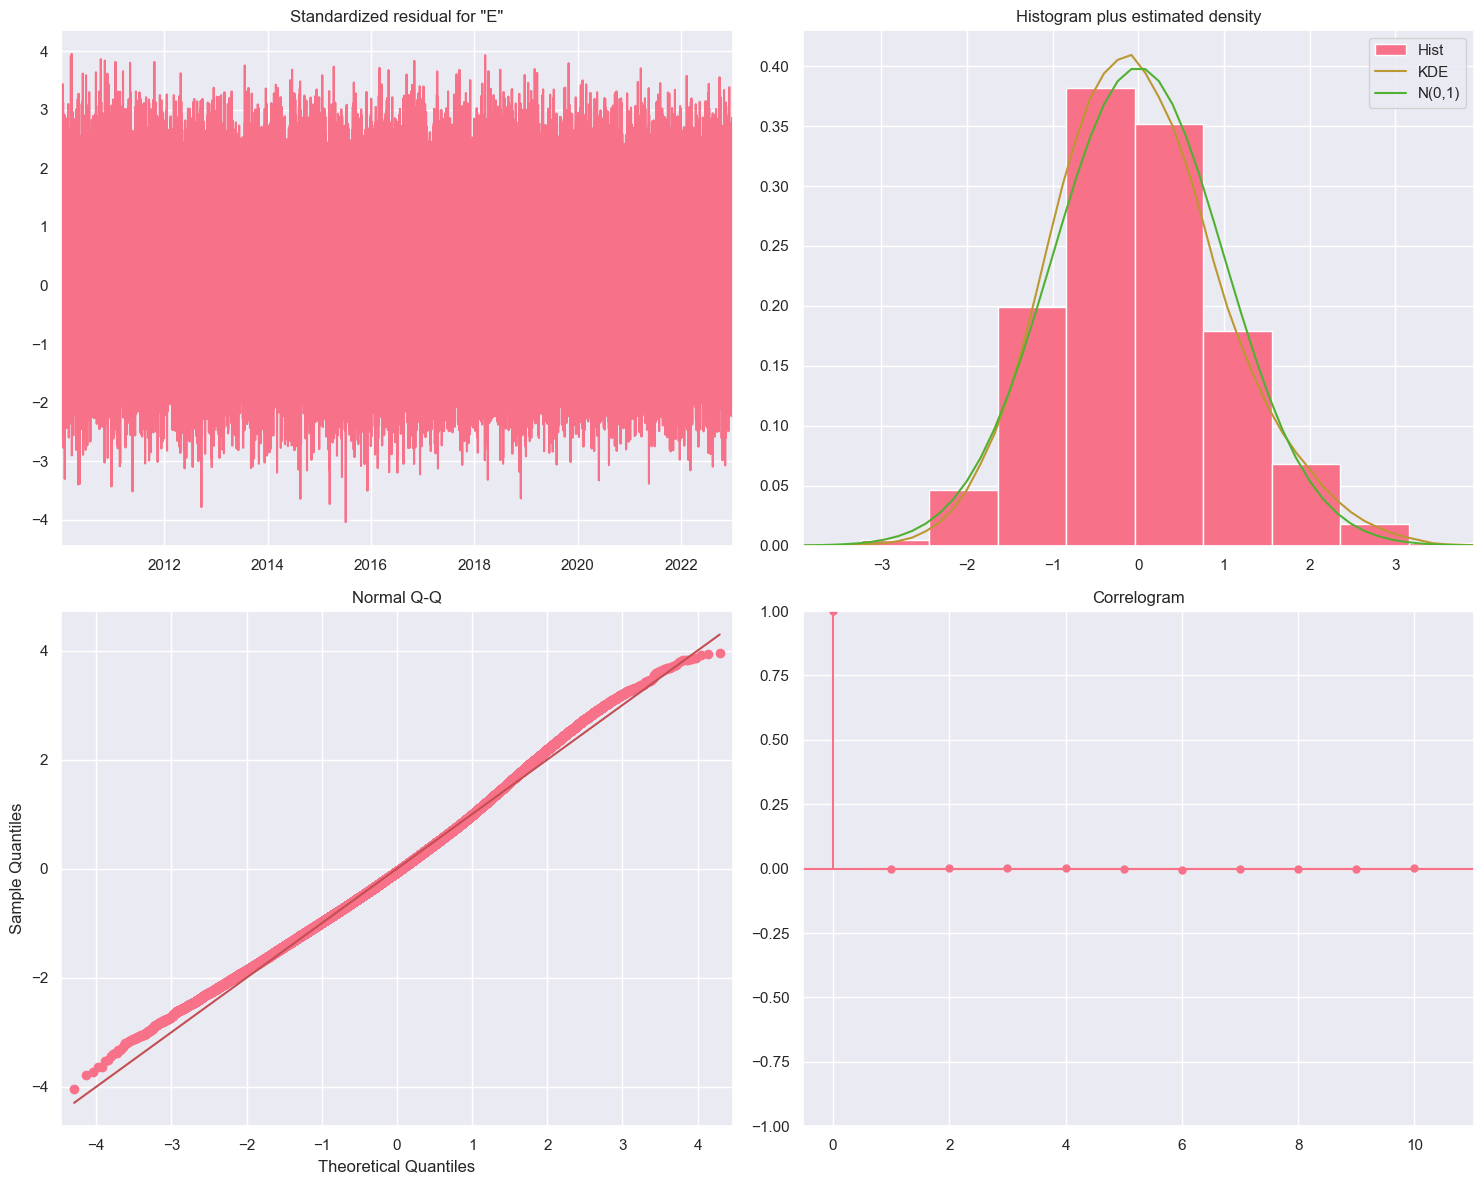

#DIAGNOSTIC PLOTS
This plot provides a diagnostic analysis of the residuals (the differences between your model's predictions and the actual values).

#Top Left (Standardized Residuals):
This shows the residuals over time. Ideally, these should look like white noise – randomly scattered around zero with no clear patterns or trends. Here, the residuals seem somewhat random but might have some periods of higher or lower variability.

#Top Right (Histogram plus estimated density):
This displays the distribution of the residuals. The histogram shows the frequency of different residual values, the red line is a Kernel Density Estimate (KDE) of the distribution, and the green line represents a standard normal distribution (N(0,1)). Ideally, the residuals should be approximately normally distributed, centered around zero. This plot suggests the residuals are somewhat close to normal but might have slightly heavier tails or be slightly skewed.
#Bottom Left (Normal Q-Q):
This is a quantile-quantile plot that compares the quantiles of your residuals to the quantiles of a standard normal distribution. If the residuals were perfectly normally distributed, the points would fall along the straight red line. Deviations from the line indicate departures from normality, particularly at the tails. Here, there are some deviations, especially at the lower and upper tails.
#Bottom Right (Correlogram):
This plot shows the autocorrelation of the residuals at different lags. Autocorrelation measures the correlation of the residuals with their past values. Ideally, for a good model, the residuals should be uncorrelated, meaning all the bars should be close to zero and within the blue shaded region (indicating non-significant autocorrelation). Here, all the autocorrelations appear to be very close to zero, suggesting the residuals are not significantly autocorrelated.

In summary, the residuals appear mostly random and not significantly autocorrelated, which are good signs. However, the normality assumption might be slightly violated based on the histogram and Q-Q plot.

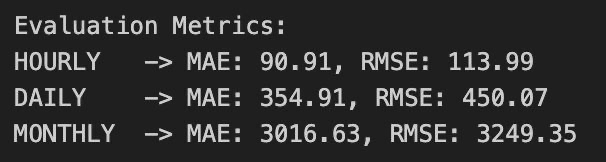

#Evaluation Metrics:
These metrics evaluate your model's forecasting accuracy at different time scales.

##HOURLY:
On an hourly basis, your model's predictions have an average absolute error (MAE) of 90.91 and a root mean squared error (RMSE) of 113.99.
##DAILY:
When looking at daily predictions, the average absolute error increases to 354.91, and the root mean squared error is 450.07.

##MONTHLY:
For monthly forecasts, the errors are significantly larger, with an MAE of 3016.63 and an RMSE of 3249.35.
Generally, the errors increase as the forecast horizon lengthens (from hourly to monthly), which is a common pattern in time series forecasting. The RMSE is consistently higher than the MAE, indicating that larger errors have a disproportionately greater impact on the RMSE.

Longer forecasts have more uncertainty, accumulate errors, lose detail, and models might fit short-term better. RMSE > MAE indicates larger prediction errors exist.

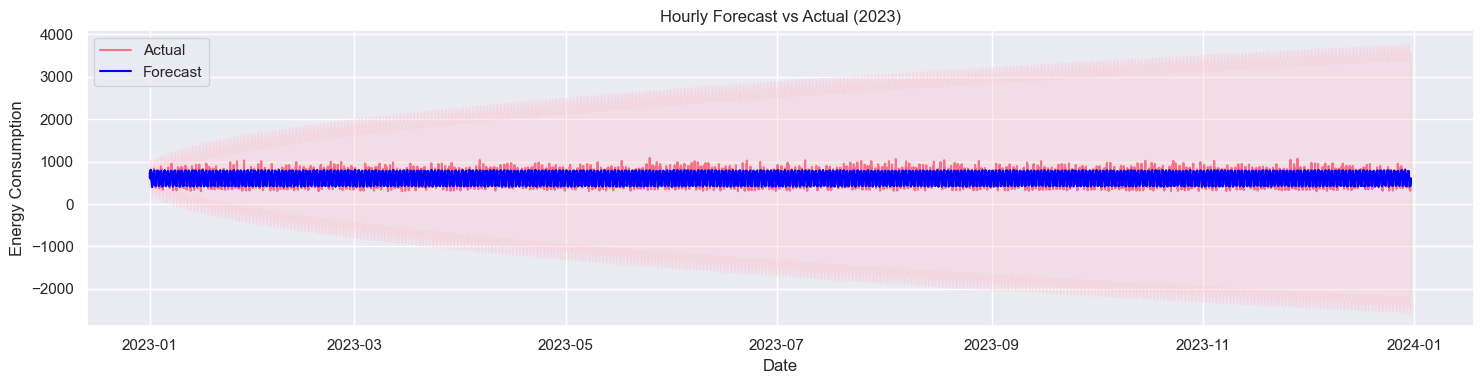

#HOURLY-ANNUAL FORECAST

This line plot compares the actual hourly energy consumption in 2023 (red line) with your model's hourly forecasts (blue line). The shaded pink area around the forecast represents the confidence interval, indicating the range within which the actual values are likely to fall according to your model's uncertainty.

Visually, the forecast line appears to follow the general level of the actual consumption, but it doesn't capture the short-term fluctuations very closely. The wide confidence interval suggests a high degree of uncertainty in the hourly predictions.

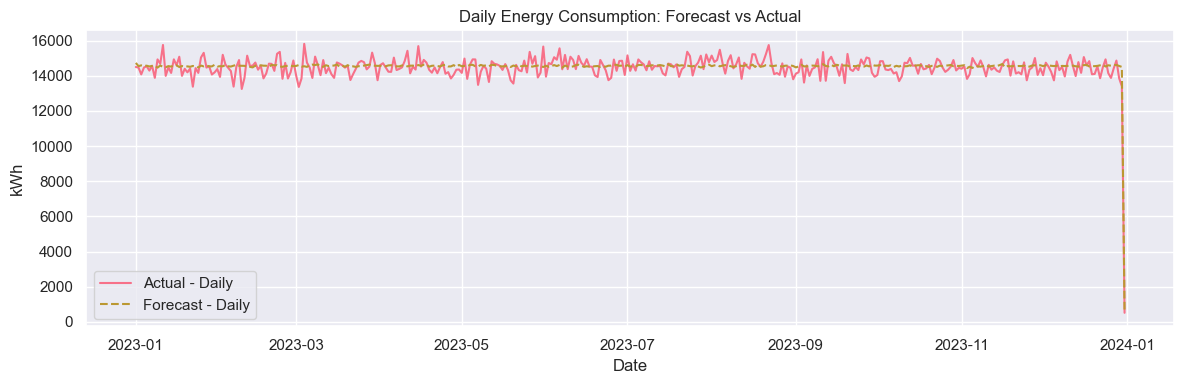

#DAILY ANNUAL FORECAST
This line plot compares the actual daily energy consumption in 2023 (pink line) with your model's daily forecasts (dashed blue line).

The forecast line generally follows the average level of the actual daily consumption throughout the year. However, it doesn't capture the day-to-day variations and appears quite flat compared to the fluctuations in the actual data. There's a sharp drop in the forecast at the very end of the period, which might indicate an issue with the model's prediction for that specific time.

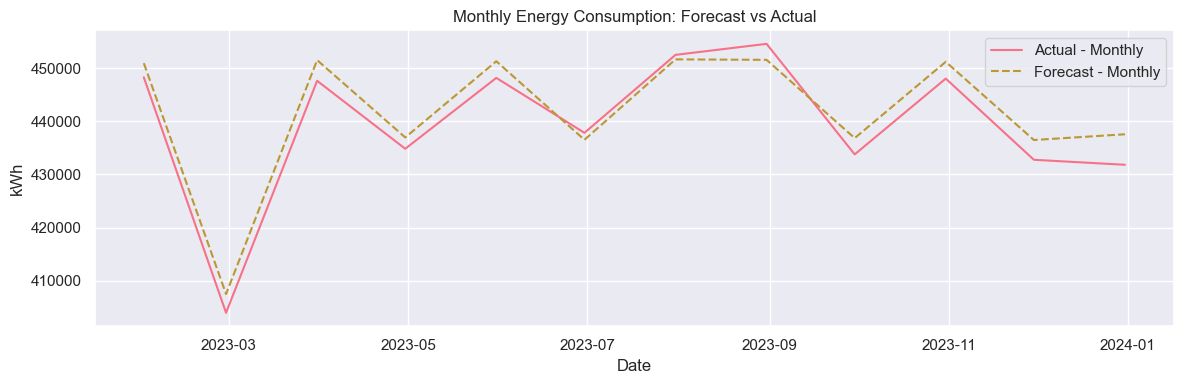

#MONTHLY ANNUAL FORECAST

This line plot compares the actual monthly energy consumption in 2023 (pink line) with your model's monthly forecasts (dashed blue line).

At a monthly level, the forecast line appears to capture the overall trend and some of the larger peaks and troughs in the actual monthly consumption. However, there are still noticeable differences in the magnitude and timing of these fluctuations between the forecast and the actual values. The model seems to follow the general direction of the monthly energy usage but doesn't perfectly predict the exact levels each month.

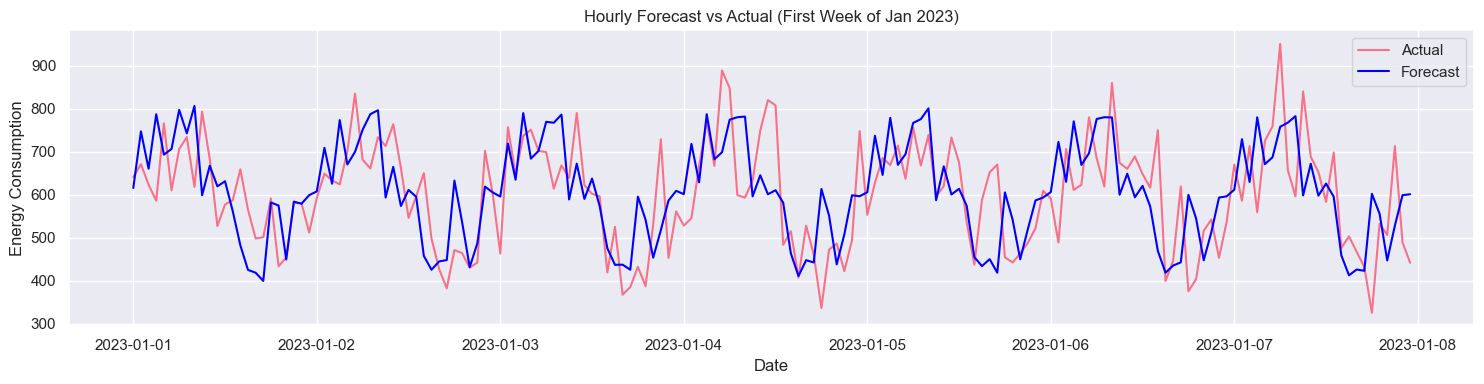

#HOURLY-WEEK FORECAST

This line plot compares the actual hourly energy consumption (pink line) with your model's hourly forecasts (blue line) for the first week of January 2023.

Looking closely, the forecast line generally follows the pattern of the actual consumption, capturing the daily peaks and troughs. However, there are noticeable differences in the exact values, with the forecast sometimes overestimating and sometimes underestimating the actual hourly energy consumption. The model captures the overall rhythm of energy usage within the week but isn't perfectly precise at each hour.



#CONCLUSION
##Model Limitations
Simplified Model Structure:

While the ARIMAX model captures both autoregressive and seasonal patterns with the use of exogenous variables and it has lower AIC and BIC scores than other models, it is relatively simple in structure: SARIMAX(1, 0, 1)x(1, 1, [], 24). This is because while we experimented with more and higher values, these created multicollinearity issues. Thus, we used a simpler version.

Residual Distribution Assumptions:

The diagnostics reveal that the residuals are not normally distributed. The data might deviate highly from the assumptions of gaussian residuals.

Limited Exogenous Variables:

The model incorporates a limited set of exogenous variables including Temperature, Humidity, Holiday, and Weekday. Other exogenous variables, such as economic indicators or weather-related data, could impact performance of the model.

Homoskedasticity of Errors: The test reveals that P(H) is 0.04. This means that errors are not homoskedastic

Lack of Exploration with Auto ARIMA:

An attempt was made to utilize auto_arima from the pmdarima library to automatically identify the optimal model order. This resulted in errors or unsatisfactory results, leading to a manual specification of the model parameters.



##Future Work
Explore Alternative Time Series Models:

Consider the application of other time series models, such as Prophet, which is specifically designed for time series with strong seasonality and holidays. Prophet may provide a more robust and accurate forecast by explicitly modeling these components.

Incorporate Additional Exogenous Variables:

Expand the set of exogenous variables to include additional factors that could influence energy consumption, such as economic indicators (GDP, employment rates), population data, and more detailed weather information (wind speed, cloud cover). These variables can help improve the model's ability to capture underlying dynamics and provide more accurate forecasts.

Implement Rolling Forecasts:

Instead of a single train-test split, use a rolling forecast approach to evaluate the model’s performance over time. Rolling forecasts involve iteratively training the model on expanding or sliding windows of historical data and testing it on future periods. This method provides a more realistic assessment of the model’s predictive capabilities and helps identify potential issues related to model stability and generalization.

Refine Model Diagnostics and Residual Analysis:

Conduct a more in-depth analysis of the model residuals to identify patterns and areas for improvement. If there is a heteroskedascity, errors can be rescaled.

Hyperparameter Tuning:

Implement hyperparameter tuning through iterative and experimentation.